## 5. ランダムフォレスト
**アンサンブル法**とは、複数の機械学習モデルを組み合わせることで、より強力なモデルを構築する手法である。  
**ランダムフォレスト**は、決定木のアンサンブルである。  
それぞれバリアンスが高い複数の決定木を平均化することで、より汎化性が高く過学習にたいして堅牢なモデルを構築する。  

1. サイズnのランダムなブートストラップ標本を復元抽出する。
2. ブートストラップ標本から決定木を成長させる。各ノードで以下の作業を行う。  
　2.1 d個の特徴量をランダムに非復元抽出する
　2.2 情報利得を最大化することにより、目的関数に従って最適な分割となる特徴量を使ってノードを分割する
3. 手順1～2をk回繰り返す
4. 決定木ごとに予測をまとめ、**多数決**に基づいてクラスラベルを割り当てる

In [43]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris.data[:,[2,3]]
y = iris.target

In [44]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1,
                            criterion="gini", # 評価指標
                            #max_features=2, # 使用する特徴量の最大数
                            #bootstrap=True, # 復元抽出の有無
                            n_estimators=100, # 決定木の数
                            class_weight="balanced", # 不均等なクラスを補正
                            n_jobs=-1)

rf.fit(X, y)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=1)

In [45]:
print(y[:5])
print(rf.predict(X[:5]))
print(rf.predict_proba(X[:5]))

[0 0 0 0 0]
[0 0 0 0 0]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [5]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier):
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cuan']
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() + 1
    x2_min, x2_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                           np.arange(x2_min, x2_max, 0.02))
    z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    z = z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, z, alpha=0.3)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1],
                    alpha=0.8,
                    label=cl, 
                    cmap=cmap,
                    edgecolor='black')

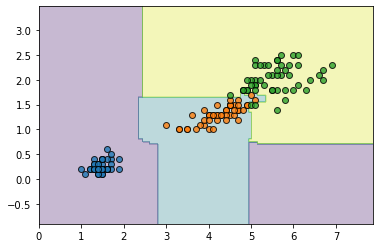

In [46]:
plot_decision_regions(X, y, rf)

#### 重要度  
ワンホットエンコーディングされた名義カテゴリは重要度が分散されてしまう  
互いに強く相関した2つの特徴量では、一方に集中してしまう

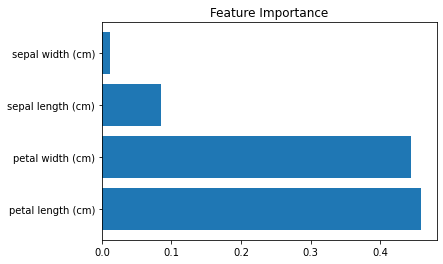

In [47]:
iris = load_iris()
X = iris.data
y = iris.target

rf = RandomForestClassifier(random_state=0, max_depth=3, n_jobs=-1)
rf.fit(X, y)
importance = rf.feature_importances_
indices = np.argsort(importance)[::-1]

names = [iris.feature_names[i] for i in indices]

plt.figure()
plt.title("Feature Importance")
plt.barh(range(X.shape[1]), importance[indices], align='center')
plt.yticks(range(X.shape[1]), names)
plt.show()

重要度による選択

In [48]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(rf, threshold=0.3)
train_importance = selector.fit_transform(X, y)
rf.fit(train_importance, y)

RandomForestClassifier(max_depth=3, n_jobs=-1, random_state=0)

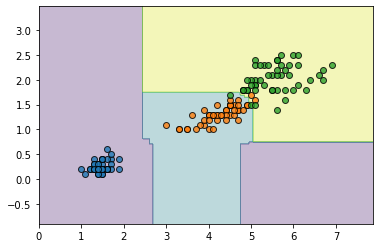

In [49]:
test_importance = selector.fit_transform(X, y)
plot_decision_regions(test_importance, y, rf)

#### ランダムフォレスト回帰
決定木同様に回帰モデルとしても利用できる。

In [32]:
from sklearn.datasets import load_boston
import pandas as pd

boston = load_boston()

X = pd.DataFrame(boston.data, columns=boston.feature_names)
X = X[['LSTAT']].values
y = boston.target

In [33]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(random_state=0, max_depth=3, n_jobs=-1)

rf_reg.fit(X, y)

RandomForestRegressor(max_depth=3, n_jobs=-1, random_state=0)

In [34]:
def lin_reg_plot(X, y, model, c):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color=c ,lw=2)
    return

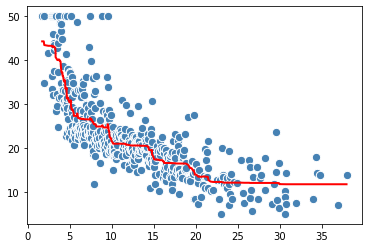

In [35]:
sort_idx = X.flatten().argsort()

lin_reg_plot(X[sort_idx], y[sort_idx], rf_reg, 'red')

#### Extra-Trees(Extremely randomized trees)
決定木では分割する際に、Gini係数やEntropyなどを基準に、利得が最大になる特徴とその分割の閾値を選択するが、  
Extra-Treesはそれらをランダムに選択する。  
このランダムな木を、ランダムフォレストと同じように複数用意してBaggingするが、  
それぞれの木を学習する際に、ブートストラップサンプリングはせずに訓練データ全てを用いる。 
  
#### 分類

In [50]:
from sklearn.ensemble import ExtraTreesClassifier

iris = load_iris()
X = iris.data[:,[2,3]]
y = iris.target

extree = ExtraTreesClassifier(random_state=0, max_depth=3, n_jobs=-1)
extree.fit(X, y)

ExtraTreesClassifier(max_depth=3, n_jobs=-1, random_state=0)

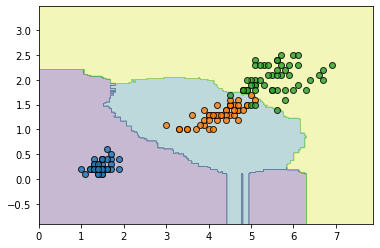

In [51]:
plot_decision_regions(X, y, extree)

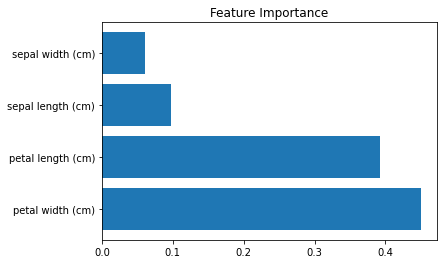

In [57]:
iris = load_iris()
X = iris.data
y = iris.target

extree = ExtraTreesClassifier(random_state=0, max_depth=3, n_jobs=-1)
extree.fit(X, y)
importance = extree.feature_importances_
indices = np.argsort(importance)[::-1]

names = [iris.feature_names[i] for i in indices]

plt.figure()
plt.title("Feature Importance")
plt.barh(range(X.shape[1]), importance[indices], align='center')
plt.yticks(range(X.shape[1]), names)
plt.show()

#### 回帰

In [55]:
from sklearn.ensemble import ExtraTreesRegressor

boston = load_boston()

X = pd.DataFrame(boston.data, columns=boston.feature_names)
X = X[['LSTAT']].values
y = boston.target

extrr_reg = ExtraTreesRegressor(random_state=0, max_depth=3, n_jobs=-1)
extrr_reg.fit(X, y)

ExtraTreesRegressor(max_depth=3, n_jobs=-1, random_state=0)

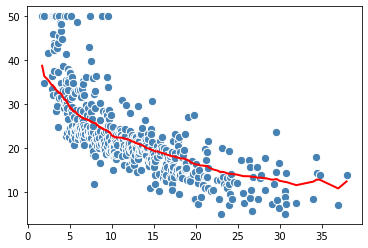

In [56]:
sort_idx = X.flatten().argsort()

lin_reg_plot(X[sort_idx], y[sort_idx], extrr_reg, 'red')